# Differentially Private Covariance

WhiteNoise offers three different functionalities within its `covariance` function:

1. Covariance between two vectors
2. Covariance matrix of a matrix
3. Cross-covariance matrix of a pair of matrices, where element $(i,j)$ of the returned matrix is the covariance of column $i$ of the left matrix and column $j$ of the right matrix.

In [1]:
# load libraries
import os
import opendp.whitenoise.core as wn
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# establish data information
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married"]

data = np.genfromtxt(data_path, delimiter=',', names=True)

### Functionality

Below we show the relationship between the three methods by calculating the same covariance in each. We use a much larger $\epsilon$ than would ever be used in practice to show that the methods are consistent with one another.   

In [2]:
with wn.Analysis() as analysis:
    wn_data = wn.Dataset(path = data_path, column_names = var_names)
    
    # get scalar covariance
    age_income_cov_scalar = wn.dp_covariance(left = wn.to_float(wn_data['age']),
                                        right = wn.to_float(wn_data['income']),
                                        privacy_usage = {'epsilon': 5000},
                                        left_lower = 0.,
                                        left_upper = 100.,
                                        left_n = 1000,
                                        right_lower = 0.,
                                        right_upper = 500_000.,
                                        right_n = 1000)
    
    # get full covariance matrix
    age_income_cov_matrix = wn.dp_covariance(data = wn.to_float(wn_data['age', 'income']),
                                           privacy_usage = {'epsilon': 5000},
                                           data_lower = [0., 0.],
                                           data_upper = [100., 500_000.],
                                           data_n = 1000)

    # get cross-covariance matrix
    cross_covar = wn.dp_covariance(left = wn.to_float(wn_data['age', 'income']),
                                   right = wn.to_float(wn_data['age', 'income']),
                                   privacy_usage = {'epsilon': 5000},
                                   left_lower = [0., 0.],
                                   left_upper = [100., 500_000.],
                                   left_n = 1_000,
                                   right_lower = [0., 0.],
                                   right_upper = [100., 500_000.],
                                   right_n = 1000)

analysis.release()
print('scalar covariance:\n{0}\n'.format(age_income_cov_scalar.value))
print('covariance matrix:\n{0}\n'.format(age_income_cov_matrix.value))    
print('cross-covariance matrix:\n{0}'.format(cross_covar.value))

scalar covariance:
[[94604.90164818]]

covariance matrix:
[[3.14895741e+02 9.44807907e+04]
 [9.44807907e+04 2.65178122e+09]]

cross-covariance matrix:
[[3.14905130e+02 9.45562356e+04]
 [9.46398233e+04 2.65112081e+09]]


### DP Covariance in Practice
  
We now move to an example with a much smaller $\epsilon$. 

In [3]:
with wn.Analysis() as analysis:
    wn_data = wn.Dataset(path = data_path, column_names = var_names)
    # get full covariance matrix
    cov = wn.dp_covariance(data = wn.to_float(wn_data['age', 'sex', 'educ', 'income', 'married']),
                                          privacy_usage = {'epsilon': 1.},
                                          data_lower = [0., 0., 1., 0., 0.],
                                          data_upper = [100., 1., 16., 500_000., 1.],
                                          data_n = 1000)
analysis.release()

# store DP covariance and correlation matrix
dp_cov = cov.value
dp_corr = dp_cov / np.outer(np.sqrt(np.diag(dp_cov)), np.sqrt(np.diag(dp_cov)))

# get non-DP covariance/correlation matrices
age = list(data[:]['age'])
sex = list(data[:]['sex'])
educ = list(data[:]['educ'])
income = list(data[:]['income'])
married = list(data[:]['married'])
non_dp_cov = np.cov([age, sex, educ, income, married])
non_dp_corr = non_dp_cov / np.outer(np.sqrt(np.diag(non_dp_cov)), np.sqrt(np.diag(non_dp_cov)))

print('Non-DP Correlation Matrix:\n{0}\n\n'.format(pd.DataFrame(non_dp_corr)))
print('DP Correlation Matrix:\n{0}'.format(pd.DataFrame(dp_corr)))

Non-DP Correlation Matrix:
          0         1         2         3         4
0  1.000000  0.055088  0.025901  0.103524  0.196072
1  0.055088  1.000000 -0.023111 -0.211106 -0.073125
2  0.025901 -0.023111  1.000000  0.305238  0.053860
3  0.103524 -0.211106  0.305238  1.000000  0.153143
4  0.196072 -0.073125  0.053860  0.153143  1.000000


DP Correlation Matrix:
          0         1         2         3         4
0  1.000000  0.108223 -0.523908  1.514256  0.170974
1  0.108223  1.000000 -0.109647 -0.395421 -0.162660
2 -0.523908 -0.109647  1.000000 -0.443592  0.184329
3  1.514256 -0.395421 -0.443592  1.000000  0.036682
4  0.170974 -0.162660  0.184329  0.036682  1.000000


[Text(0, 0.5, 'age'),
 Text(0, 1.5, 'sex'),
 Text(0, 2.5, 'educ'),
 Text(0, 3.5, 'income'),
 Text(0, 4.5, 'married')]

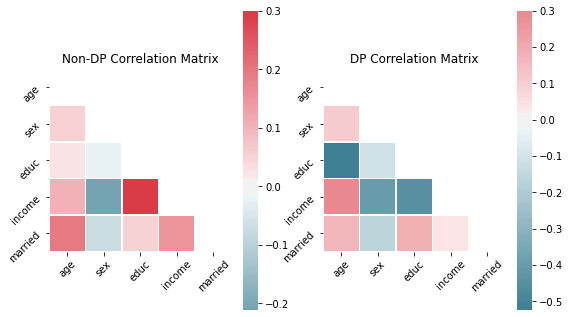

In [4]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize = (9, 11))

# generate a mask for the upper triangular matrix
mask = np.triu(np.ones_like(non_dp_corr, dtype = np.bool))

# generate color palette
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# get correlation plots
ax_1.title.set_text('Non-DP Correlation Matrix')
sns.heatmap(non_dp_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax_1)
ax_1.set_xticklabels(labels = ['age', 'sex', 'educ', 'income', 'married'], rotation = 45)
ax_1.set_yticklabels(labels = ['age', 'sex', 'educ', 'income', 'married'], rotation = 45)


ax_2.title.set_text('DP Correlation Matrix')
sns.heatmap(dp_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax_2)
ax_2.set_xticklabels(labels = ['age', 'sex', 'educ', 'income', 'married'], rotation = 45)
ax_2.set_yticklabels(labels = ['age', 'sex', 'educ', 'income', 'married'], rotation = 45)



Notice that the differentially private correlation matrix contains values outside of the feasible range for correlations, $[-1, 1]$. This is not uncommon, especially for analyses with small $\epsilon$, and is not necessarily indicative of a problem. In this scenario, we will not use these correlations for anything other than visualization, so we will leave our result as is.

Sometimes, you may get a result that does cause problems for downstream analysis. For example, say your differentially private covariance matrix is not positive semi-definite. There are a number of ways to deal with problems of this type.

1. Relax your original plans: For example, if you want to invert your DP covariance matrix and are unable to do so, you could instead take the pseudoinverse.
2. Manual Post-Processing: Choose some way to change the output such that it is consistent with what you need for later analyses. This changed output is still differentially private (we will use this idea again in the next section). For example, map all negative variances to small postive value.
3. More releases: You could perform the same release again (perhaps with a larger $\epsilon$) and combine your results in some way until you have a release that works for your purposes.  Note that additional $\epsilon$ from will be consumed everytime this happens.  

### Post-Processing of DP Covariance Matrix: Regression Coefficient

Differentially private outputs are "immune" to post-processing, meaning that functions of diffrentially private releases are also differentially private (provided that the functions are independent of the underlying data about which the release was made). This idea provides us with a relatively easy way to generate complex differentially private releases from simpler ones.

Say we wanted to run a linear regression of the form $income = \alpha + \beta \cdot educ$ and want to find an differentially private estimate of the slope, $\hat{\beta}_{DP}$. We know that 
$$ \beta = \frac{cov(income, educ)}{var(educ)}, $$ 
and so 
$$ \hat{\beta}_{DP} = \frac{\hat{cov}(income, educ)_{DP}}{ \hat{var}(educ)_{DP} }. $$

We already have differentially private esimates of the necessary covariance and variance, so we can plug them in to find $\hat{\beta}_{DP}$.



In [5]:
'''income = alpha + beta * educ'''
# find DP estimate of beta
beta_hat_dp = dp_cov[2,3] / dp_cov[2,2]
beta_hat = non_dp_cov[2,3] / non_dp_cov[2,2]

print('income = alpha + beta * educ')
print('DP coefficient: {0}'.format(beta_hat_dp))
print('Non-DP Coefficient: {0}'.format(beta_hat))

income = alpha + beta * educ
DP coefficient: -7216.246125609213
Non-DP Coefficient: 4601.803740280991


This result is obviously implausible, as it would suggest that an extra year of education is associated with, on average, a decrease in annual income of over $7,000. It's not uncommon for this to be the case for DP releases constructed as post-processing from other releases, especially when they involve taking ratios. 

If you find yourself in such as situation, it is often worth it to spend some extra privacy budget to estimate your quantity of interest using an algorithm optimized for that specific use case.